# Captcha Recognition

## Data Analysis

In [1]:
# Get dataset directory path
DATASET_DIR = "./data"

Load all the images in the directory specified by DATASET_DIR and store the file names in the captcha_list array. 

Additionally, extract the unique characters present in the file names to determine the total number of distinct characters used in the dataset, which will be used as labels.

In [2]:
import os

captcha_list = []  # List to store image names
characters = {} # Dictionary to store the frequency of each unique character in the dataset

for captcha in os.listdir(DATASET_DIR):
    captcha_list.append(captcha)

    # Extract the captcha code (without extension) from the file name
    captcha_code = captcha.split(".")[0]
    
    for char in captcha_code:
        # Increment the count for the character in the characters dictionary,
        # or initialize it to 1 if the character is not already present
        characters[char] = characters.get(char, 0) + 1
        
# Get all unique characters from the keys of the characters dictionary
characters_keys = list(characters.keys())

# Print the total number of unique characters and the list of characters
print(f'Total unique characters: {len(characters_keys)}')
print(f'Unique characters: {characters_keys}')

Total unique characters: 19
Unique characters: ['2', '6', 'm', 'd', '5', 'n', '3', 'g', '8', '4', 'e', 'y', 'f', 'w', 'p', '7', 'c', 'x', 'b']


In [3]:
# Check the total number of captcha images
print(f'Total number of captcha images: {len(captcha_list)}')

Total number of captcha images: 1067


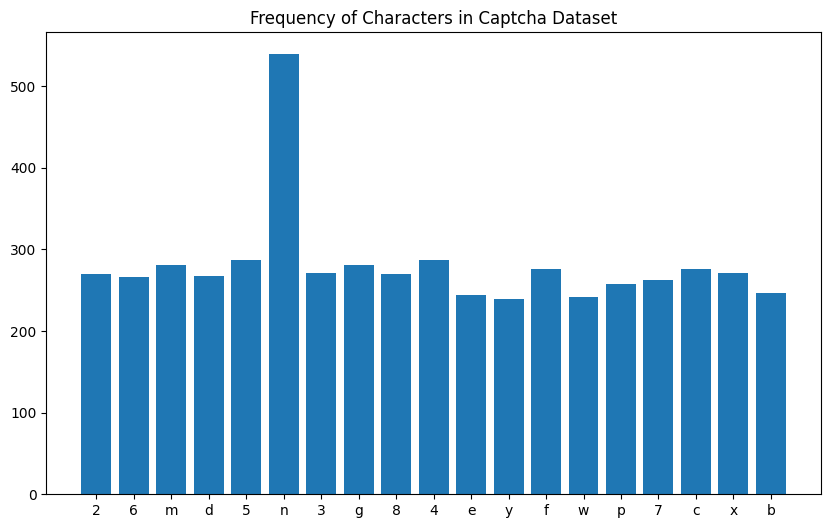

In [4]:
import matplotlib.pyplot as plt

# Visualize the frequency of characters
plt.figure(figsize=(10, 6))
# plt.bar(list(characters.keys()), list(characters.values()))
plt.bar(*zip(*characters.items())) # Another way to plot the frequency of characters
plt.title('Frequency of Characters in Captcha Dataset')
plt.show()

Simplify way to process of unpacking and transposing the dictionary.

In [5]:
# Unpack the key-value pairs into tuples
print(*characters.items())

('2', 270) ('6', 266) ('m', 281) ('d', 268) ('5', 287) ('n', 539) ('3', 271) ('g', 281) ('8', 270) ('4', 287) ('e', 244) ('y', 239) ('f', 276) ('w', 242) ('p', 258) ('7', 262) ('c', 276) ('x', 271) ('b', 247)


In [6]:
# Group the key-value pairs into tuples of keys and tuples of values
print(*zip(*characters.items()))

('2', '6', 'm', 'd', '5', 'n', '3', 'g', '8', '4', 'e', 'y', 'f', 'w', 'p', '7', 'c', 'x', 'b') (270, 266, 281, 268, 287, 539, 271, 281, 270, 287, 244, 239, 276, 242, 258, 262, 276, 271, 247)


## Preprocess Data

In [7]:
import numpy as np

IMG_SHAPE = (50, 200, 1)  # height, width, channels (grayscale)
NUM_SAMPLES = len(captcha_list)
NUM_CHARACTERS = len(characters_keys)
LEN_CAPTCHA = 5

# Initialize arrays to store the images and labels
X = np.zeros((NUM_SAMPLES, *IMG_SHAPE)) # NUM_SAMPLES, height, width, channels, 1070 * (50 * 200 * 1)
y = np.zeros((LEN_CAPTCHA, NUM_SAMPLES, NUM_CHARACTERS)) # 5 * 1070 * 19

In [8]:
import cv2

for idx, captcha in enumerate(captcha_list):
    captcha_code = captcha.split('.')[0] # Extract the captcha code (without extension)
    captcha_image = cv2.imread(os.path.join(DATASET_DIR, captcha), cv2.IMREAD_GRAYSCALE)
    captcha_image = captcha_image / 255.0 # Normalize pixel values
    
    captcha_image = np.reshape(captcha_image, IMG_SHAPE) # Reshape the image to match img_shape
    targets = np.zeros((LEN_CAPTCHA, NUM_CHARACTERS)) # Initialize the targets array
    
    # Convert the captcha code into a one-hot encoded format and store it in the targets array
    for i, char in enumerate(captcha_code):
        targets[i, characters_keys.index(char)] = 1
    
    # Store the preprocessed image in the X array
    X[idx] = captcha_image
    
    # Store the one-hot encoded labels in the y array
    y[:, idx] = targets

In [9]:
print("shape of X:", X.shape) # 1070 images with dimensions (50 * 200 * 1)
print("shape of y:", y.shape) # 5 sets of labels for 1070 samples, each with 19 classes (one-hot encoded)

shape of X: (1067, 50, 200, 1)
shape of y: (5, 1067, 19)


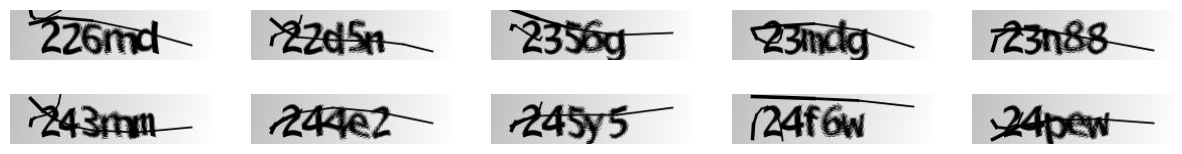

In [10]:
# Display the first 10 input images in X array
plt.figure(figsize=(15, 2))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i], cmap='gray')
    plt.axis('off')

plt.show()

Since this is a multi-output problem and we cannot use scikit-learn's train_test_split function directly, we manually split the data into training (60%), validation (20%), and test (20%) sets.

In [11]:
# Set the random seed for reproducibility
np.random.seed(42)

# Calculate the number of samples for each set
NUM_SAMPLES = X.shape[0]
NUM_TRAIN = int(0.6 * NUM_SAMPLES)
NUM_VAL = int(0.2 * NUM_SAMPLES)
NUM_TEST = int(0.2 * NUM_SAMPLES)

# Shuffle the indices
indices = np.random.permutation(NUM_SAMPLES)

# Split the indices into train, validation, and test sets
train_indices = indices[:NUM_TRAIN]
val_indices = indices[NUM_TRAIN:NUM_TRAIN + NUM_VAL]
test_indices = indices[NUM_TRAIN + NUM_VAL:]

# Split the data using the indices
X_train, y_train = X[train_indices], y[:, train_indices]
X_val, y_val = X[val_indices], y[:, val_indices]
X_test, y_test = X[test_indices], y[:, test_indices]

# Print the shapes of the resulting datasets
print("Train set shapes:", X_train.shape, y_train.shape)
print("Validation set shapes:", X_val.shape, y_val.shape)
print("Test set shapes:", X_test.shape, y_test.shape)

Train set shapes: (640, 50, 200, 1) (5, 640, 19)
Validation set shapes: (213, 50, 200, 1) (5, 213, 19)
Test set shapes: (214, 50, 200, 1) (5, 214, 19)


## Build Model

In [12]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, Dense, Input
from tensorflow.keras.models import Model

# Build model architecture function
def build_captcha_model(input_shape, num_classes):
    # Define input layer
    inputs = Input(shape=input_shape, name='input')
    
    # Convolutional layers
    x = Conv2D(32, (5, 5), padding='valid', activation='relu')(inputs)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x_2 = MaxPooling2D((2, 2), padding='same')(x) # Intermediate pooling layer
    
    # Define outputs list to store output of each character prediction
    outputs = []
    for i in range(5):
        # Shared convolutional layers
        x = Conv2D(256, (3, 3), padding='same', activation='relu')(x_2)
        x = MaxPooling2D((2, 2), padding='same')(x)
        
        # Flatten layer
        x = Flatten()(x)
        
        # Dropout and BatchNormalization layers
        x = Dropout(0.5)(x)
        x = BatchNormalization()(x)
        
        # Fully connected layers
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.5)(x)
        x = BatchNormalization()(x)
        
        # Output layer for each character prediction
        x = Dense(num_classes, activation='softmax', name=f'char_{i+1}')(x)
        outputs.append(x)

    # Define the model with input and output layers
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [13]:
# Build the model
model = build_captcha_model(IMG_SHAPE, NUM_CHARACTERS)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 50, 200, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 46, 196, 32)  832         ['input[0][0]']                  
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 23, 98, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 23, 98, 64)   18496       ['max_pooling2d[0][0]']      

 dropout_1 (Dropout)            (None, 64)           0           ['dense[0][0]']                  
                                                                                                  
 dropout_3 (Dropout)            (None, 64)           0           ['dense_1[0][0]']                
                                                                                                  
 dropout_5 (Dropout)            (None, 64)           0           ['dense_2[0][0]']                
                                                                                                  
 dropout_7 (Dropout)            (None, 64)           0           ['dense_3[0][0]']                
                                                                                                  
 dropout_9 (Dropout)            (None, 64)           0           ['dense_4[0][0]']                
                                                                                                  
 batch_nor

## Train Model

In [14]:
# Hyperparameter
BATCH_SIZE = 32
EPOCHS = 100

In [15]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Compile the model with specified optimizer and loss function
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

history = model.fit(X_train, 
                    [y_train[i] for i in range(5)], 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    validation_data=(X_val, [y_val[i] for i in range(5)]),
                    callbacks=[reduce_lr, early_stop])

Epoch 1/100
20/20 [==============================] - 45s 2s/step - loss: 18.1046 - char_1_loss: 3.5963 - char_2_loss: 3.5859 - char_3_loss: 3.6320 - char_4_loss: 3.7024 - char_5_loss: 3.5879 - char_1_accuracy: 0.0531 - char_2_accuracy: 0.0656 - char_3_accuracy: 0.0344 - char_4_accuracy: 0.0531 - char_5_accuracy: 0.0500 - val_loss: 14.8757 - val_char_1_loss: 2.9713 - val_char_2_loss: 2.9817 - val_char_3_loss: 2.9790 - val_char_4_loss: 2.9870 - val_char_5_loss: 2.9566 - val_char_1_accuracy: 0.0329 - val_char_2_accuracy: 0.0469 - val_char_3_accuracy: 0.0469 - val_char_4_accuracy: 0.0329 - val_char_5_accuracy: 0.0376 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - 38s 2s/step - loss: 17.6865 - char_1_loss: 3.5307 - char_2_loss: 3.5766 - char_3_loss: 3.5184 - char_4_loss: 3.5012 - char_5_loss: 3.5595 - char_1_accuracy: 0.0703 - char_2_accuracy: 0.0578 - char_3_accuracy: 0.0734 - char_4_accuracy: 0.0516 - char_5_accuracy: 0.0422 - val_loss: 14.8486 - val_char_1_loss: 2.9553

Epoch 14/100
20/20 [==============================] - 26s 1s/step - loss: 4.2144 - char_1_loss: 0.5839 - char_2_loss: 0.7252 - char_3_loss: 0.9509 - char_4_loss: 1.0818 - char_5_loss: 0.8726 - char_1_accuracy: 0.9297 - char_2_accuracy: 0.8656 - char_3_accuracy: 0.8047 - char_4_accuracy: 0.7594 - char_5_accuracy: 0.8156 - val_loss: 10.0645 - val_char_1_loss: 1.7221 - val_char_2_loss: 1.9453 - val_char_3_loss: 2.0996 - val_char_4_loss: 2.1597 - val_char_5_loss: 2.1377 - val_char_1_accuracy: 0.7700 - val_char_2_accuracy: 0.6808 - val_char_3_accuracy: 0.5681 - val_char_4_accuracy: 0.5117 - val_char_5_accuracy: 0.5164 - lr: 0.0010
Epoch 15/100
20/20 [==============================] - 25s 1s/step - loss: 3.6413 - char_1_loss: 0.5241 - char_2_loss: 0.5875 - char_3_loss: 0.8270 - char_4_loss: 0.9546 - char_5_loss: 0.7480 - char_1_accuracy: 0.9281 - char_2_accuracy: 0.9250 - char_3_accuracy: 0.8281 - char_4_accuracy: 0.8109 - char_5_accuracy: 0.8578 - val_loss: 9.6122 - val_char_1_loss: 1.6354 

Epoch 27/100
20/20 [==============================] - 25s 1s/step - loss: 1.2002 - char_1_loss: 0.1779 - char_2_loss: 0.1999 - char_3_loss: 0.2603 - char_4_loss: 0.3199 - char_5_loss: 0.2423 - char_1_accuracy: 0.9922 - char_2_accuracy: 0.9828 - char_3_accuracy: 0.9734 - char_4_accuracy: 0.9672 - char_5_accuracy: 0.9828 - val_loss: 3.2344 - val_char_1_loss: 0.3458 - val_char_2_loss: 0.6032 - val_char_3_loss: 0.6899 - val_char_4_loss: 0.8876 - val_char_5_loss: 0.7079 - val_char_1_accuracy: 0.9718 - val_char_2_accuracy: 0.9531 - val_char_3_accuracy: 0.9296 - val_char_4_accuracy: 0.8732 - val_char_5_accuracy: 0.9484 - lr: 0.0010
Epoch 28/100
20/20 [==============================] - 18s 896ms/step - loss: 1.0730 - char_1_loss: 0.1729 - char_2_loss: 0.1946 - char_3_loss: 0.2268 - char_4_loss: 0.2743 - char_5_loss: 0.2044 - char_1_accuracy: 0.9922 - char_2_accuracy: 0.9891 - char_3_accuracy: 0.9859 - char_4_accuracy: 0.9719 - char_5_accuracy: 0.9844 - val_loss: 2.3733 - val_char_1_loss: 0.256

Epoch 40/100
20/20 [==============================] - 18s 904ms/step - loss: 0.6077 - char_1_loss: 0.1006 - char_2_loss: 0.1034 - char_3_loss: 0.1320 - char_4_loss: 0.1580 - char_5_loss: 0.1136 - char_1_accuracy: 0.9906 - char_2_accuracy: 0.9922 - char_3_accuracy: 0.9859 - char_4_accuracy: 0.9828 - char_5_accuracy: 0.9922 - val_loss: 0.8969 - val_char_1_loss: 0.0337 - val_char_2_loss: 0.1947 - val_char_3_loss: 0.2372 - val_char_4_loss: 0.3192 - val_char_5_loss: 0.1122 - val_char_1_accuracy: 1.0000 - val_char_2_accuracy: 0.9531 - val_char_3_accuracy: 0.9484 - val_char_4_accuracy: 0.9155 - val_char_5_accuracy: 0.9812 - lr: 0.0010
Epoch 41/100
20/20 [==============================] - 24s 1s/step - loss: 0.5374 - char_1_loss: 0.0805 - char_2_loss: 0.0959 - char_3_loss: 0.1244 - char_4_loss: 0.1336 - char_5_loss: 0.1029 - char_1_accuracy: 0.9984 - char_2_accuracy: 0.9922 - char_3_accuracy: 0.9922 - char_4_accuracy: 0.9891 - char_5_accuracy: 0.9969 - val_loss: 0.8342 - val_char_1_loss: 0.026

Epoch 53/100
20/20 [==============================] - 25s 1s/step - loss: 0.4261 - char_1_loss: 0.0721 - char_2_loss: 0.0727 - char_3_loss: 0.0886 - char_4_loss: 0.0927 - char_5_loss: 0.0999 - char_1_accuracy: 0.9953 - char_2_accuracy: 0.9953 - char_3_accuracy: 0.9906 - char_4_accuracy: 0.9937 - char_5_accuracy: 0.9859 - val_loss: 0.6643 - val_char_1_loss: 0.0248 - val_char_2_loss: 0.1517 - val_char_3_loss: 0.1955 - val_char_4_loss: 0.2439 - val_char_5_loss: 0.0485 - val_char_1_accuracy: 0.9906 - val_char_2_accuracy: 0.9624 - val_char_3_accuracy: 0.9531 - val_char_4_accuracy: 0.9202 - val_char_5_accuracy: 0.9953 - lr: 0.0010
Epoch 54/100
20/20 [==============================] - 24s 1s/step - loss: 0.3739 - char_1_loss: 0.0522 - char_2_loss: 0.0757 - char_3_loss: 0.0777 - char_4_loss: 0.0786 - char_5_loss: 0.0897 - char_1_accuracy: 0.9969 - char_2_accuracy: 0.9953 - char_3_accuracy: 0.9922 - char_4_accuracy: 0.9953 - char_5_accuracy: 0.9937 - val_loss: 0.6275 - val_char_1_loss: 0.0170 -

Epoch 66/100
20/20 [==============================] - 20s 979ms/step - loss: 0.3250 - char_1_loss: 0.0479 - char_2_loss: 0.0618 - char_3_loss: 0.0663 - char_4_loss: 0.0915 - char_5_loss: 0.0574 - char_1_accuracy: 0.9969 - char_2_accuracy: 0.9922 - char_3_accuracy: 0.9906 - char_4_accuracy: 0.9875 - char_5_accuracy: 0.9953 - val_loss: 0.6241 - val_char_1_loss: 0.0082 - val_char_2_loss: 0.1581 - val_char_3_loss: 0.1684 - val_char_4_loss: 0.2500 - val_char_5_loss: 0.0393 - val_char_1_accuracy: 1.0000 - val_char_2_accuracy: 0.9577 - val_char_3_accuracy: 0.9577 - val_char_4_accuracy: 0.9296 - val_char_5_accuracy: 0.9953 - lr: 0.0010
Epoch 67/100
20/20 [==============================] - 23s 1s/step - loss: 0.3163 - char_1_loss: 0.0597 - char_2_loss: 0.0563 - char_3_loss: 0.0615 - char_4_loss: 0.0830 - char_5_loss: 0.0559 - char_1_accuracy: 0.9906 - char_2_accuracy: 0.9953 - char_3_accuracy: 0.9984 - char_4_accuracy: 0.9922 - char_5_accuracy: 0.9937 - val_loss: 0.6079 - val_char_1_loss: 0.008

Epoch 79/100
20/20 [==============================] - 24s 1s/step - loss: 0.2513 - char_1_loss: 0.0310 - char_2_loss: 0.0485 - char_3_loss: 0.0600 - char_4_loss: 0.0613 - char_5_loss: 0.0505 - char_1_accuracy: 0.9984 - char_2_accuracy: 0.9937 - char_3_accuracy: 0.9906 - char_4_accuracy: 0.9937 - char_5_accuracy: 0.9969 - val_loss: 0.5676 - val_char_1_loss: 0.0072 - val_char_2_loss: 0.1562 - val_char_3_loss: 0.1527 - val_char_4_loss: 0.2162 - val_char_5_loss: 0.0353 - val_char_1_accuracy: 1.0000 - val_char_2_accuracy: 0.9531 - val_char_3_accuracy: 0.9531 - val_char_4_accuracy: 0.9296 - val_char_5_accuracy: 1.0000 - lr: 4.0000e-05
Epoch 80/100
20/20 [==============================] - 24s 1s/step - loss: 0.2191 - char_1_loss: 0.0362 - char_2_loss: 0.0369 - char_3_loss: 0.0497 - char_4_loss: 0.0642 - char_5_loss: 0.0321 - char_1_accuracy: 0.9984 - char_2_accuracy: 1.0000 - char_3_accuracy: 0.9969 - char_4_accuracy: 0.9953 - char_5_accuracy: 0.9984 - val_loss: 0.5609 - val_char_1_loss: 0.00

## Evaluate Model

In [29]:
# Evaluate the model on the test data
metrics = model.evaluate(X_test, [y_test[i] for i in range(5)])

# Extracting loss and accuracy for each output
total_loss = metrics[0]
losses = metrics[1:6]
accuracies = metrics[6:]

# Print out the evaluation results for each output
print(f"Loss:", total_loss)
for i in range(5):
    print(f"Character {i+1} Loss:", losses[i])
    print(f"Character {i+1} Accuracy:", accuracies[i])

Loss: 0.848078191280365
Character 1 Loss: 0.007433142978698015
Character 1 Accuracy: 1.0
Character 2 Loss: 0.23071984946727753
Character 2 Accuracy: 0.9299065470695496
Character 3 Loss: 0.29745981097221375
Character 3 Accuracy: 0.9112149477005005
Character 4 Loss: 0.21565592288970947
Character 4 Accuracy: 0.9392523169517517
Character 5 Loss: 0.096809521317482
Character 5 Accuracy: 0.9672897458076477


## Save Model & Labels

Saving the character keys would be beneficial for prediction, as it allows mapping the prediction results to the corresponding characters.

In [17]:
# Path to save the characters_keys list
CHARACTERS_KEYS_PATH = "./characters_keys.txt"

# Save the characters_keys list to a text file
with open(CHARACTERS_KEYS_PATH, 'w') as f:
    for char in characters_keys:
        f.write(f"{char}\n")

print("Characters keys saved successfully.")

Characters keys saved successfully.


In [18]:
import tensorflow as tf

# TensorFlow Serving requires each model version to be in a separate directory,
# so I put the model inside the "1" folder (indicating version 1)
MODEL_PATH = "./models/captcha-ocr-model/1"

# Save the model to the SavedModel format
tf.saved_model.save(model, MODEL_PATH)

INFO:tensorflow:Assets written to: ./models/captcha-ocr-model/1\assets


INFO:tensorflow:Assets written to: ./models/captcha-ocr-model/1\assets


## Prediction Test

Before deploying the model and testing it in production, it's a better idea to load the model locally and try predicting on local data to ensure the prediction works accurately. 

Often, issues arise when preprocessing the prediction data to match the format of the training data. Common problems include mismatches in shape and other preprocessing issues.

In [19]:
# Function to preprocess the image
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (200, 50))
    img = img.astype(np.float32) # Convert to float32
    img = img[..., np.newaxis] # Add channel dimension
    img = img / 255.0 # normalize
    
    return img

In [20]:
# Saved model and characters keys path
MODEL_PATH = "./models/captcha-ocr-model/1"
CHARACTERS_KEYS_PATH = "./characters_keys.txt"

In [21]:
# Load the saved model
model = tf.saved_model.load(MODEL_PATH)
model

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x1f58418f710>

In [22]:
# Load the characters_keys list from the text file
characters_keys = []
with open(CHARACTERS_KEYS_PATH, 'r') as f:
    for line in f:
        characters_keys.append(line.strip())

# Now characters_keys contains the loaded list
print(f'Loaded characters keys: {characters_keys}')

Loaded characters keys: ['2', '6', 'm', 'd', '5', 'n', '3', 'g', '8', '4', 'e', 'y', 'f', 'w', 'p', '7', 'c', 'x', 'b']


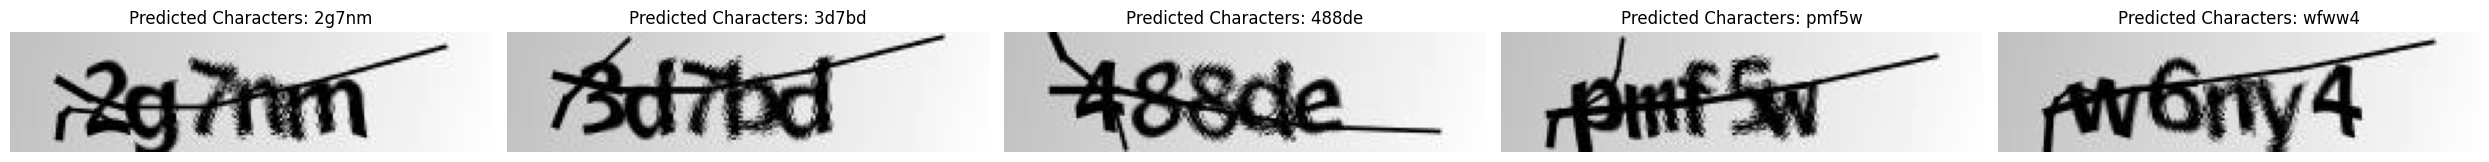

In [23]:
import os
import matplotlib.pyplot as plt

# Path to the folder containing prediction images
PREDICTION_DATA_FOLDER = "./prediction_data"

# Set up subplots
NUM_IMAGES = len(os.listdir(PREDICTION_DATA_FOLDER))
NUM_COLS = NUM_IMAGES
fig, axes = plt.subplots(1, NUM_COLS, figsize=(5*NUM_COLS, 5))

# Iterate over all files in the folder
for i, filename in enumerate(os.listdir(PREDICTION_DATA_FOLDER)):
    # Get the path to the image
    img_path = os.path.join(PREDICTION_DATA_FOLDER, filename)
    
    # Get the prediction image
    img = preprocess_image(img_path)

    # Add a new axis to the input image array
    expanded_img = np.expand_dims(img, axis=0)

    # Make prediction
    predictions = model(expanded_img)

    # Process predictions
    predicted_chars = ''.join(characters_keys[np.argmax(pred)] for pred in predictions)

    # Display the image and predicted characters
    ax = axes[i]
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Predicted Characters: {predicted_chars}')

# Show the subplots
plt.tight_layout()
plt.show()